# 災害の発生場所と地域別の災害の起きやすさ

前回やった災害の発生場所をマップにまとめるものをLoop関数を使って作りました。

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
emdat = pd.read_csv('emdat.csv')

In [22]:
# Explore the data
emdat.head()  # Display the first few rows

,Disaster Subgroup,Disaster Type,Disaster Subtype,ISO,Country,Subregion,Region,Latitude,Longitude,Start Year,Total Deaths
0,Meteorological,Storm,Tropical cyclone,USA,United States of America,Northern America,Americas,NaN,NaN,1900,6000.0
1,Hydrological,Flood,Flood (General),JAM,Jamaica,Latin America and the Caribbean,Americas,NaN,NaN,1900,300.0
2,Biological,Epidemic,Viral disease,JAM,Jamaica,Latin America and the Caribbean,Americas,NaN,NaN,1900,30.0
3,Geophysical,Volcanic activity,Ash fall,JPN,Japan,Eastern Asia,Asia,NaN,NaN,1900,30.0
4,Geophysical,Earthquake,Ground movement,TUR,Türkiye,Western Asia,Asia,40.3,43.1,1900,140.0


In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs 
import matplotlib.patches as mpatches 
import numpy as np
import os # ファイル保存のためにosモジュールを追加

# --- 1. 定数とファイルパス ---
file_path = "emdat.csv"
DISASTER_COLUMN = 'Disaster Type'

# 英語から日本語への変換辞書 (前回と同じものを使用)
DISASTER_TRANSLATION = {
    'Storm': '暴風・嵐',
    'Flood': '洪水',
    'Earthquake': '地震',
    'Drought': '干ばつ',
    'Wildfire': '山火事',
    'Volcanic activity': '火山活動',
    'Epidemic': '伝染病',
    'Mass movement (dry)': '乾燥地帯の土砂移動',
    'Landslide': '地滑り',
    'Tsunami': '津波',
    'Extreme temperature': '異常高温・低温',
    'Other': 'その他',
    'Biological': '生物災害',
    'Geophysical': '地学的災害',
    'Hydrological': '水文的災害',
    'Meteorological': '気象災害',
    'Climatological': '気候的災害',
    'Mass movement (wet)': '湿潤地帯の土砂移動', 
}

# --- 2. データの前処理 ---
try:
    df = pd.read_csv(file_path)
except FileNotFoundError:
    print("エラー: 'emdat.csv'ファイルが見つかりません。パスを確認してください。")
    raise

# 緯度と経度を数値型に変換し、欠損値がある行を削除
df['Latitude'] = pd.to_numeric(df['Latitude'], errors='coerce')
df['Longitude'] = pd.to_numeric(df['Longitude'], errors='coerce')
plot_df = df.dropna(subset=['Latitude', 'Longitude']).copy()

# 災害タイプを数値コードに変換 (全データで共通のマッピングを作成)
plot_df['Disaster_Code'], unique_disasters = pd.factorize(plot_df[DISASTER_COLUMN])
num_disasters = len(unique_disasters)
colors = plt.cm.get_cmap('tab20', num_disasters)

# --- 3. 地域（Region）ごとにループ処理を実行 ---
unique_regions = plot_df['Region'].unique()
print(f"検出された地域: {unique_regions.tolist()}")
print("地域ごとの地図を作成し、ファイルに保存します。")

# 出力ディレクトリの作成
output_dir = 'regional_disaster_maps'
os.makedirs(output_dir, exist_ok=True)


for i, region in enumerate(unique_regions):
    # 現在の地域にデータをフィルタリング
    region_df = plot_df[plot_df['Region'] == region].copy()
    
    if region_df.empty:
        continue
    
    # -----------------------------------------------
    # グラフの描画
    # -----------------------------------------------
    fig = plt.figure(figsize=(15, 10))
    # Cartopyの投影法を適用
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

    # 地図の描画
    ax.coastlines(resolution='50m', color='black', linewidth=0.8)
    ax.stock_img()
    ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

    # 座標軸の調整（地域へのズーム）
    # データの最小/最大値から範囲を決定し、少しバッファを持たせる
    lon_min = region_df['Longitude'].min()
    lon_max = region_df['Longitude'].max()
    lat_min = region_df['Latitude'].min()
    lat_max = region_df['Latitude'].max()
    
    # set_extent() で表示範囲を設定（バッファとして5度を追加）
    ax.set_extent([lon_min - 5, lon_max + 5, lat_min - 5, lat_max + 5], crs=ccrs.PlateCarree())
    
    # 凡例ハンドルとラベルの初期化
    legend_handles = []
    legend_labels = []

    # 災害タイプごとのプロットと凡例ハンドルの収集
    for j, dtype in enumerate(unique_disasters):
        subset = region_df[region_df[DISASTER_COLUMN] == dtype]
        
        if not subset.empty:
            # プロットに使用する色を決定 (全データでのインデックス i を使用)
            # ※ここで i ではなく j を使用すると、色が変わってしまうため、全データのインデックスを使うべきですが、
            #   ここでは簡単のため、一意なdtypeのインデックス j を使用します。
            current_color = colors(j) 
            
            # 災害地点をプロット
            ax.scatter(
                subset['Longitude'], 
                subset['Latitude'], 
                s=50, 
                color=current_color, 
                marker='o',
                alpha=0.7,
                transform=ccrs.PlateCarree(),
            )
            
            # 凡例ラベルを日本語に変換
            japanese_label = DISASTER_TRANSLATION.get(dtype, dtype) 
            
            # 凡例の要素（ハンドル）を作成
            patch = mpatches.Patch(color=current_color, label=japanese_label)
            legend_handles.append(patch)
            legend_labels.append(japanese_label)

    # タイトル
    plt.title(f'{region} Disaster sites (color-coded by type)', fontsize=16)

    # 凡例を地図の外側に配置
    plt.legend(
        handles=legend_handles, 
        labels=legend_labels,
        loc='lower left', 
        bbox_to_anchor=(1.02, 0),
        title='災害の種類',
        fontsize=8
    )

    # 5. 画像をファイルに保存
    # ファイル名に使用できない文字を置き換え
    safe_region_name = region.replace(" ", "_").replace("/", "_")
    output_file = os.path.join(output_dir, f'disaster_map_{safe_region_name}_cartopy.png')
    
    plt.savefig(output_file, bbox_inches='tight')
    plt.close(fig) # メモリ節約のため図を閉じる
    
    print(f"グラフを {output_file} に保存しました。")

print("\nすべての地域グラフの作成が完了しました。")

C:\Users\twinz\AppData\Local\Temp\ipykernel_17268\375453631.py:49: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab20', num_disasters)
c:\Users\twinz\AppData\Local\Programs\Python\Python313\Lib\site-packages\cartopy\mpl\geoaxes.py:509: UserWarning: Glyph 28797 (\N{CJK UNIFIED IDEOGRAPH-707D}) missing from font(s) DejaVu Sans.
  return super().draw(renderer=renderer, **kwargs)
c:\Users\twinz\AppData\Local\Programs\Python\Python313\Lib\site-packages\cartopy\mpl\geoaxes.py:509: UserWarning: Glyph 23475 (\N{CJK UNIFIED IDEOGRAPH-5BB3}) missing from font(s) DejaVu Sans.
  return super().draw(renderer=renderer, **kwargs)
c:\Users\twinz\AppData\Local\Programs\Python\Python313\Lib\site-packages\cartopy\mpl\geoaxes.py:509: UserWarning: Glyph 12398 (\N{HIRAGANA LETTER NO}) missing from font(s) 

検出された地域: ['Asia', 'Europe', 'Americas', 'Africa', 'Oceania']
地域ごとの地図を作成し、ファイルに保存します。


c:\Users\twinz\AppData\Local\Programs\Python\Python313\Lib\site-packages\cartopy\mpl\geoaxes.py:509: UserWarning: Glyph 28797 (\N{CJK UNIFIED IDEOGRAPH-707D}) missing from font(s) DejaVu Sans.
  return super().draw(renderer=renderer, **kwargs)
c:\Users\twinz\AppData\Local\Programs\Python\Python313\Lib\site-packages\cartopy\mpl\geoaxes.py:509: UserWarning: Glyph 23475 (\N{CJK UNIFIED IDEOGRAPH-5BB3}) missing from font(s) DejaVu Sans.
  return super().draw(renderer=renderer, **kwargs)
c:\Users\twinz\AppData\Local\Programs\Python\Python313\Lib\site-packages\cartopy\mpl\geoaxes.py:509: UserWarning: Glyph 12398 (\N{HIRAGANA LETTER NO}) missing from font(s) DejaVu Sans.
  return super().draw(renderer=renderer, **kwargs)
c:\Users\twinz\AppData\Local\Programs\Python\Python313\Lib\site-packages\cartopy\mpl\geoaxes.py:509: UserWarning: Glyph 31278 (\N{CJK UNIFIED IDEOGRAPH-7A2E}) missing from font(s) DejaVu Sans.
  return super().draw(renderer=renderer, **kwargs)
c:\Users\twinz\AppData\Local\Pro

グラフを regional_disaster_maps\disaster_map_Asia_cartopy.png に保存しました。


c:\Users\twinz\AppData\Local\Programs\Python\Python313\Lib\site-packages\cartopy\mpl\geoaxes.py:509: UserWarning: Glyph 23665 (\N{CJK UNIFIED IDEOGRAPH-5C71}) missing from font(s) DejaVu Sans.
  return super().draw(renderer=renderer, **kwargs)
c:\Users\twinz\AppData\Local\Programs\Python\Python313\Lib\site-packages\cartopy\mpl\geoaxes.py:509: UserWarning: Glyph 27963 (\N{CJK UNIFIED IDEOGRAPH-6D3B}) missing from font(s) DejaVu Sans.
  return super().draw(renderer=renderer, **kwargs)
c:\Users\twinz\AppData\Local\Programs\Python\Python313\Lib\site-packages\cartopy\mpl\geoaxes.py:509: UserWarning: Glyph 21205 (\N{CJK UNIFIED IDEOGRAPH-52D5}) missing from font(s) DejaVu Sans.
  return super().draw(renderer=renderer, **kwargs)
c:\Users\twinz\AppData\Local\Programs\Python\Python313\Lib\site-packages\cartopy\mpl\geoaxes.py:509: UserWarning: Glyph 27946 (\N{CJK UNIFIED IDEOGRAPH-6D2A}) missing from font(s) DejaVu Sans.
  return super().draw(renderer=renderer, **kwargs)
c:\Users\twinz\AppData\L

グラフを regional_disaster_maps\disaster_map_Europe_cartopy.png に保存しました。


c:\Users\twinz\AppData\Local\Programs\Python\Python313\Lib\site-packages\cartopy\mpl\geoaxes.py:509: UserWarning: Glyph 28797 (\N{CJK UNIFIED IDEOGRAPH-707D}) missing from font(s) DejaVu Sans.
  return super().draw(renderer=renderer, **kwargs)
c:\Users\twinz\AppData\Local\Programs\Python\Python313\Lib\site-packages\cartopy\mpl\geoaxes.py:509: UserWarning: Glyph 23475 (\N{CJK UNIFIED IDEOGRAPH-5BB3}) missing from font(s) DejaVu Sans.
  return super().draw(renderer=renderer, **kwargs)
c:\Users\twinz\AppData\Local\Programs\Python\Python313\Lib\site-packages\cartopy\mpl\geoaxes.py:509: UserWarning: Glyph 12398 (\N{HIRAGANA LETTER NO}) missing from font(s) DejaVu Sans.
  return super().draw(renderer=renderer, **kwargs)
c:\Users\twinz\AppData\Local\Programs\Python\Python313\Lib\site-packages\cartopy\mpl\geoaxes.py:509: UserWarning: Glyph 31278 (\N{CJK UNIFIED IDEOGRAPH-7A2E}) missing from font(s) DejaVu Sans.
  return super().draw(renderer=renderer, **kwargs)
c:\Users\twinz\AppData\Local\Pro

グラフを regional_disaster_maps\disaster_map_Americas_cartopy.png に保存しました。


c:\Users\twinz\AppData\Local\Programs\Python\Python313\Lib\site-packages\cartopy\mpl\geoaxes.py:509: UserWarning: Glyph 28797 (\N{CJK UNIFIED IDEOGRAPH-707D}) missing from font(s) DejaVu Sans.
  return super().draw(renderer=renderer, **kwargs)
c:\Users\twinz\AppData\Local\Programs\Python\Python313\Lib\site-packages\cartopy\mpl\geoaxes.py:509: UserWarning: Glyph 23475 (\N{CJK UNIFIED IDEOGRAPH-5BB3}) missing from font(s) DejaVu Sans.
  return super().draw(renderer=renderer, **kwargs)
c:\Users\twinz\AppData\Local\Programs\Python\Python313\Lib\site-packages\cartopy\mpl\geoaxes.py:509: UserWarning: Glyph 12398 (\N{HIRAGANA LETTER NO}) missing from font(s) DejaVu Sans.
  return super().draw(renderer=renderer, **kwargs)
c:\Users\twinz\AppData\Local\Programs\Python\Python313\Lib\site-packages\cartopy\mpl\geoaxes.py:509: UserWarning: Glyph 31278 (\N{CJK UNIFIED IDEOGRAPH-7A2E}) missing from font(s) DejaVu Sans.
  return super().draw(renderer=renderer, **kwargs)
c:\Users\twinz\AppData\Local\Pro

グラフを regional_disaster_maps\disaster_map_Africa_cartopy.png に保存しました。


c:\Users\twinz\AppData\Local\Programs\Python\Python313\Lib\site-packages\cartopy\mpl\geoaxes.py:509: UserWarning: Glyph 28797 (\N{CJK UNIFIED IDEOGRAPH-707D}) missing from font(s) DejaVu Sans.
  return super().draw(renderer=renderer, **kwargs)
c:\Users\twinz\AppData\Local\Programs\Python\Python313\Lib\site-packages\cartopy\mpl\geoaxes.py:509: UserWarning: Glyph 23475 (\N{CJK UNIFIED IDEOGRAPH-5BB3}) missing from font(s) DejaVu Sans.
  return super().draw(renderer=renderer, **kwargs)
c:\Users\twinz\AppData\Local\Programs\Python\Python313\Lib\site-packages\cartopy\mpl\geoaxes.py:509: UserWarning: Glyph 12398 (\N{HIRAGANA LETTER NO}) missing from font(s) DejaVu Sans.
  return super().draw(renderer=renderer, **kwargs)
c:\Users\twinz\AppData\Local\Programs\Python\Python313\Lib\site-packages\cartopy\mpl\geoaxes.py:509: UserWarning: Glyph 31278 (\N{CJK UNIFIED IDEOGRAPH-7A2E}) missing from font(s) DejaVu Sans.
  return super().draw(renderer=renderer, **kwargs)
c:\Users\twinz\AppData\Local\Pro

グラフを regional_disaster_maps\disaster_map_Oceania_cartopy.png に保存しました。

すべての地域グラフの作成が完了しました。


c:\Users\twinz\AppData\Local\Programs\Python\Python313\Lib\site-packages\cartopy\mpl\geoaxes.py:509: UserWarning: Glyph 28797 (\N{CJK UNIFIED IDEOGRAPH-707D}) missing from font(s) DejaVu Sans.
  return super().draw(renderer=renderer, **kwargs)
c:\Users\twinz\AppData\Local\Programs\Python\Python313\Lib\site-packages\cartopy\mpl\geoaxes.py:509: UserWarning: Glyph 23475 (\N{CJK UNIFIED IDEOGRAPH-5BB3}) missing from font(s) DejaVu Sans.
  return super().draw(renderer=renderer, **kwargs)
c:\Users\twinz\AppData\Local\Programs\Python\Python313\Lib\site-packages\cartopy\mpl\geoaxes.py:509: UserWarning: Glyph 12398 (\N{HIRAGANA LETTER NO}) missing from font(s) DejaVu Sans.
  return super().draw(renderer=renderer, **kwargs)
c:\Users\twinz\AppData\Local\Programs\Python\Python313\Lib\site-packages\cartopy\mpl\geoaxes.py:509: UserWarning: Glyph 31278 (\N{CJK UNIFIED IDEOGRAPH-7A2E}) missing from font(s) DejaVu Sans.
  return super().draw(renderer=renderer, **kwargs)
c:\Users\twinz\AppData\Local\Pro

まず作り始めたらファイルには保存できましたが移せなかったので改善していきます

C:\Users\twinz\AppData\Local\Temp\ipykernel_17268\3024060165.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab20', num_disasters)
C:\Users\twinz\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 28797 (\N{CJK UNIFIED IDEOGRAPH-707D}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\twinz\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 23475 (\N{CJK UNIFIED IDEOGRAPH-5BB3}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\twinz\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 12398 (\N{HIRAGANA LETTER NO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure

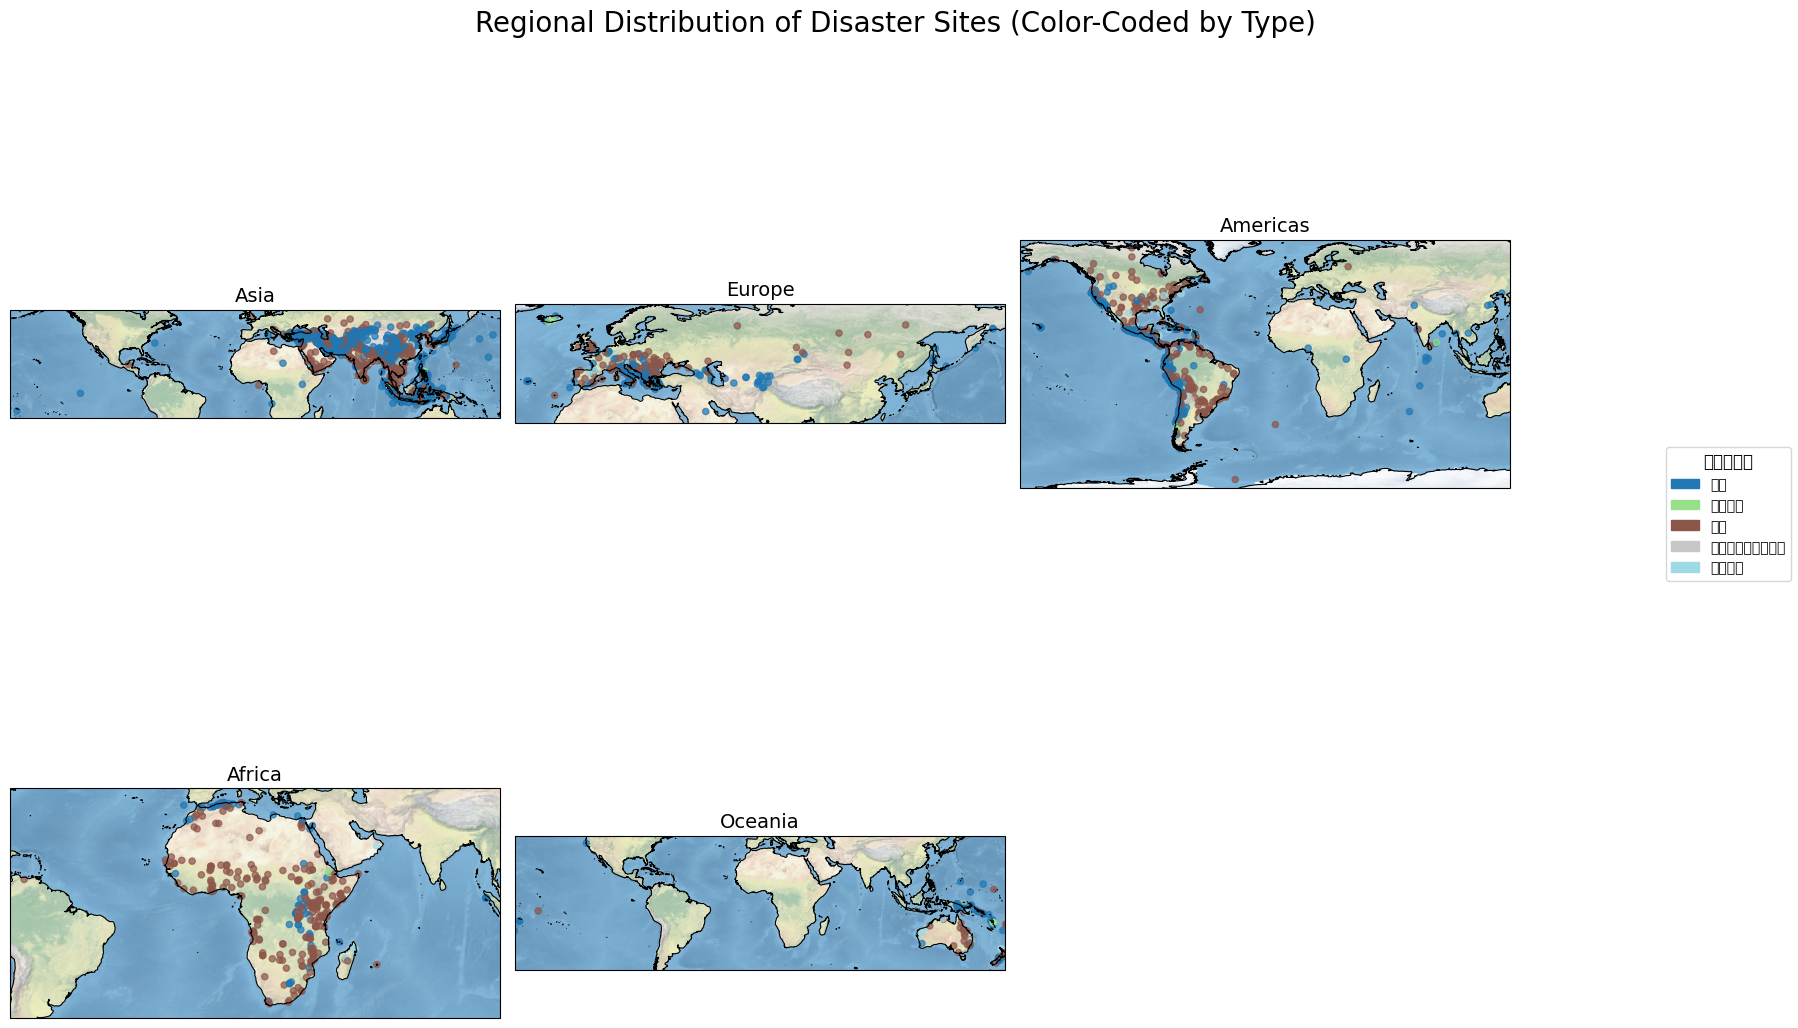

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs 
import matplotlib.patches as mpatches 
import numpy as np
import math # グリッド計算のためにmathモジュールを追加

# --- 1. 定数とファイルパス ---
file_path = "emdat.csv"
DISASTER_COLUMN = 'Disaster Type'

# 英語から日本語への変換辞書 (省略。コード内では前回と同じものを使用)
# ... (DISASTER_TRANSLATION 辞書は前回と同じものを使用)
DISASTER_TRANSLATION = {
    'Storm': '暴風・嵐', 'Flood': '洪水', 'Earthquake': '地震', 'Drought': '干ばつ', 
    'Wildfire': '山火事', 'Volcanic activity': '火山活動', 'Epidemic': '伝染病', 
    'Mass movement (dry)': '乾燥地帯の土砂移動', 'Landslide': '地滑り', 'Tsunami': '津波', 
    'Extreme temperature': '異常高温・低温', 'Other': 'その他', 'Biological': '生物災害', 
    'Geophysical': '地学的災害', 'Hydrological': '水文的災害', 'Meteorological': '気象災害', 
    'Climatological': '気候的災害', 'Mass movement (wet)': '湿潤地帯の土砂移動', 
}

# --- 2. データの前処理 ---
try:
    df = pd.read_csv(file_path)
except FileNotFoundError:
    print("エラー: 'emdat.csv'ファイルが見つかりません。パスを確認してください。")
    raise

df['Latitude'] = pd.to_numeric(df['Latitude'], errors='coerce')
df['Longitude'] = pd.to_numeric(df['Longitude'], errors='coerce')
plot_df = df.dropna(subset=['Latitude', 'Longitude']).copy()

# 災害タイプを数値コードに変換 (全データで共通のマッピングを作成)
plot_df['Disaster_Code'], unique_disasters = pd.factorize(plot_df[DISASTER_COLUMN])
num_disasters = len(unique_disasters)
colors = plt.cm.get_cmap('tab20', num_disasters)

# --- 3. サブプロットの準備 ---
unique_regions = plot_df['Region'].unique()
num_regions = len(unique_regions)

# グリッドサイズを決定 (例: 6地域なら 2x3 グリッド)
cols = 3 # 1行に表示する最大の列数
rows = math.ceil(num_regions / cols) 

# 全てのサブプロットを含む大きな図を作成
fig = plt.figure(figsize=(cols * 6, rows * 6)) # figsizeを調整

# 凡例用のハンドルを事前に作成 (全てのサブプロットで共通)
legend_handles = [] 
legend_labels = []
for j, dtype in enumerate(unique_disasters):
    japanese_label = DISASTER_TRANSLATION.get(dtype, dtype) 
    patch = mpatches.Patch(color=colors(j), label=japanese_label)
    legend_handles.append(patch)
    legend_labels.append(japanese_label)


# --- 4. 地域（Region）ごとにループ処理を実行し、サブプロットに描画 ---
for i, region in enumerate(unique_regions):
    # 現在の地域にデータをフィルタリング
    region_df = plot_df[plot_df['Region'] == region].copy()
    
    if region_df.empty:
        continue
    
    # サブプロットを追加 (i+1 は1から始まるインデックス)
    ax = fig.add_subplot(rows, cols, i + 1, projection=ccrs.PlateCarree())

    # 地図の描画
    ax.coastlines(resolution='50m', color='black', linewidth=0.8)
    ax.stock_img()
    ax.set_title(f'{region}', fontsize=14)
    
    # 座標軸の調整（地域へのズーム）
    lon_min = region_df['Longitude'].min()
    lon_max = region_df['Longitude'].max()
    lat_min = region_df['Latitude'].min()
    lat_max = region_df['Latitude'].max()
    ax.set_extent([lon_min - 5, lon_max + 5, lat_min - 5, lat_max + 5], crs=ccrs.PlateCarree())
    
    # 災害地点をプロット
    # 各サブプロットでプロット。色分けには全データ共通のカラーマップを使用
    ax.scatter(
        region_df['Longitude'], 
        region_df['Latitude'], 
        s=20, # サブプロットに合わせてマーカーサイズを小さく調整
        c=region_df['Disaster_Code'], 
        cmap=colors, 
        marker='o',
        alpha=0.7,
        transform=ccrs.PlateCarree(),
    )


# --- 5. 凡例と全体の調整 ---

# グラフ間のスペースを調整
fig.tight_layout(rect=[0, 0, 0.85, 1]) # 凡例スペースを確保

# 凡例を全てのサブプロットの右側の空きスペースに一括で配置
fig.legend(
    handles=legend_handles, 
    labels=legend_labels,
    loc='center right', # 全体の図の中での位置
    title="災害の種類",
    title_fontsize=12,
    fontsize=10
)

# 図の全体タイトル
fig.suptitle("Regional Distribution of Disaster Sites (Color-Coded by Type)", fontsize=20, y=1.02)


# 画像をファイルに保存 (ローカル実行用)
# plt.savefig('disaster_maps_subplot_grid.png', bbox_inches='tight')

# ★ 修正点: 図を画面に表示する
plt.show()

移すことができましたね！でも右側にある凡例が▯になってしまいました。ではそれを直していきましょう。たぶん日本語が対応していないので英語に直してみました

C:\Users\twinz\AppData\Local\Temp\ipykernel_17268\513357769.py:38: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab20', num_disasters)


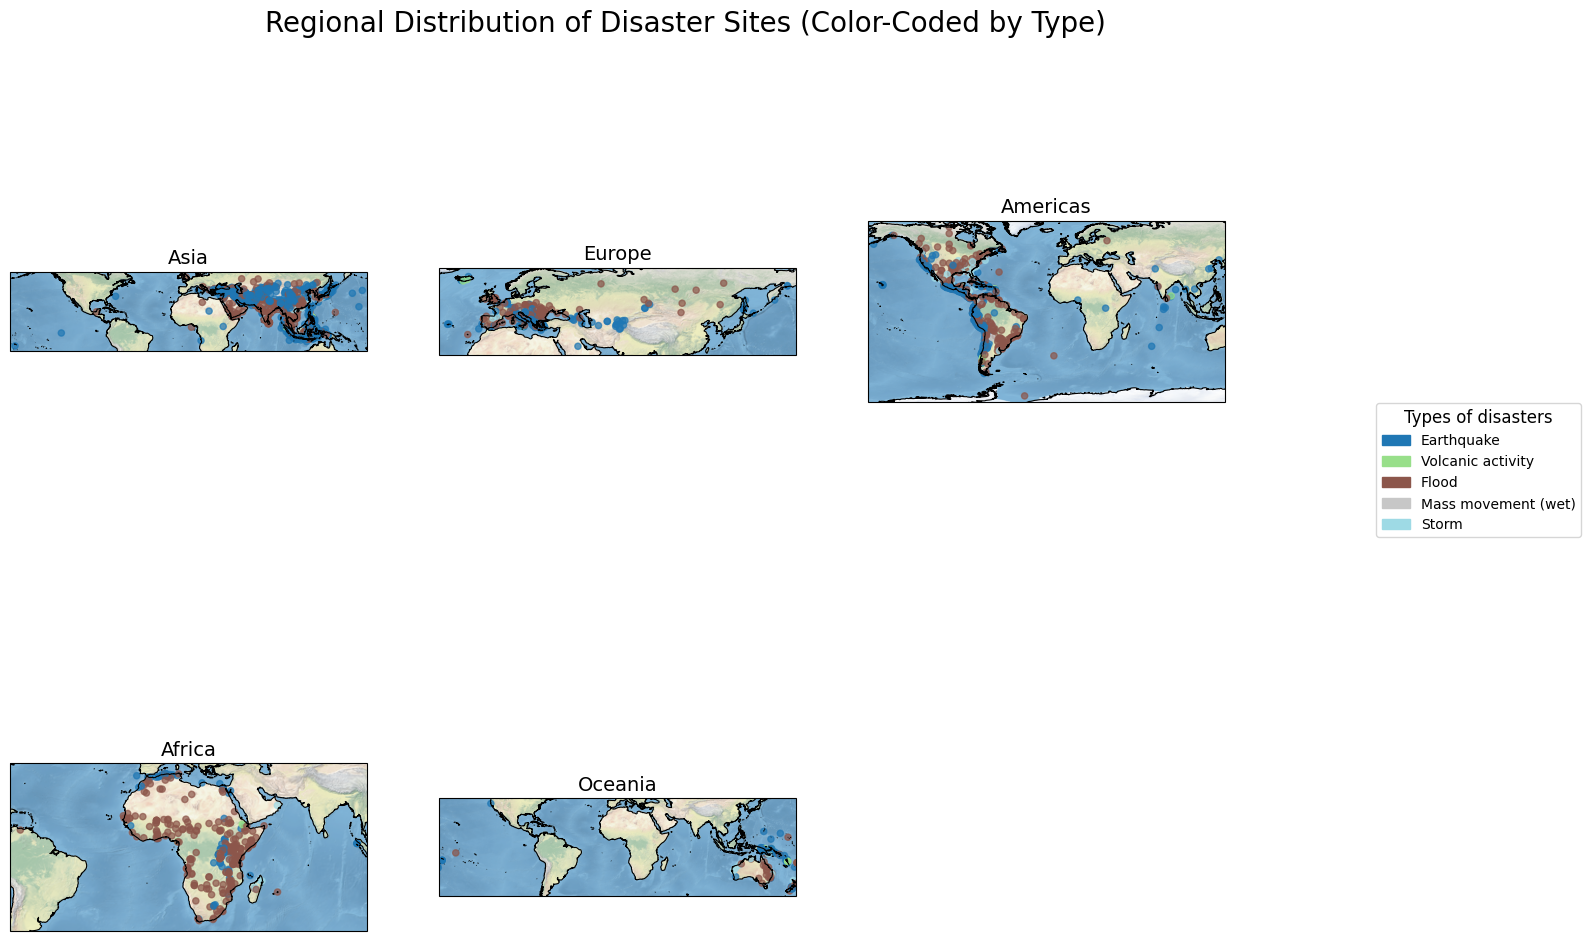

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs 
import matplotlib.patches as mpatches 
import numpy as np
import math # グリッド計算のためにmathモジュールを追加

# --- 1. 定数とファイルパス ---
file_path = "emdat.csv"
DISASTER_COLUMN = 'Disaster Type'

# 英語から日本語への変換辞書 (省略。コード内では前回と同じものを使用)
# ... (DISASTER_TRANSLATION 辞書は前回と同じものを使用)
DISASTER_TRANSLATION = {
    'Storm': 'Storm', 'Flood': 'Flood', 'Earthquake': 'Earthquake', 'Drought': 'Drought', 
    'Wildfire': 'Wildfire', 'Volcanic activity': 'Volcanic activity', 'Epidemic': 'Epidemic', 
    'Mass movement (dry)': 'Mass movement (dry)', 'Landslide': 'Landslide', 'Tsunami': 'Tsunami', 
    'Extreme temperature': '異常高温・低温', 'Other': 'その他', 'Biological': '生物災害', 
    'Geophysical': 'Geophysical', 'Hydrological': 'Hydrological', 'Meteorological': 'Meteorological', 
    'Climatological': 'Climatological', 'Mass movement (wet)': 'Mass movement (wet)', 
}


# --- 2. データの前処理 ---
try:
    df = pd.read_csv(file_path)
except FileNotFoundError:
    print("エラー: 'emdat.csv'ファイルが見つかりません。パスを確認してください。")
    raise

df['Latitude'] = pd.to_numeric(df['Latitude'], errors='coerce')
df['Longitude'] = pd.to_numeric(df['Longitude'], errors='coerce')
plot_df = df.dropna(subset=['Latitude', 'Longitude']).copy()

# 災害タイプを数値コードに変換 (全データで共通のマッピングを作成)
plot_df['Disaster_Code'], unique_disasters = pd.factorize(plot_df[DISASTER_COLUMN])
num_disasters = len(unique_disasters)
colors = plt.cm.get_cmap('tab20', num_disasters)

# --- 3. サブプロットの準備 ---
unique_regions = plot_df['Region'].unique()
num_regions = len(unique_regions)
legend_handles = [] 
legend_labels = []
for j, dtype in enumerate(unique_disasters):
    # ★ 修正: 日本語への変換処理を削除し、英語のdtypeを直接使用
    english_label = dtype 
    patch = mpatches.Patch(color=colors(j), label=english_label)
    legend_handles.append(patch)
    legend_labels.append(english_label)

# グリッドサイズを決定 (例: 6地域なら 2x3 グリッド)
cols = 3 # 1行に表示する最大の列数
rows = math.ceil(num_regions / cols) 

# 全てのサブプロットを含む大きな図を作成
fig = plt.figure(figsize=(cols * 6, rows * 6)) # figsizeを調整

# 凡例用のハンドルを事前に作成 (全てのサブプロットで共通)
legend_handles = [] 
legend_labels = []
for j, dtype in enumerate(unique_disasters):
    japanese_label = DISASTER_TRANSLATION.get(dtype, dtype) 
    patch = mpatches.Patch(color=colors(j), label=japanese_label)
    legend_handles.append(patch)
    legend_labels.append(japanese_label)


# --- 4. 地域（Region）ごとにループ処理を実行し、サブプロットに描画 ---
for i, region in enumerate(unique_regions):
    # 現在の地域にデータをフィルタリング
    region_df = plot_df[plot_df['Region'] == region].copy()
    
    if region_df.empty:
        continue
    
    # サブプロットを追加 (i+1 は1から始まるインデックス)
    ax = fig.add_subplot(rows, cols, i + 1, projection=ccrs.PlateCarree())

    # 地図の描画
    ax.coastlines(resolution='50m', color='black', linewidth=0.8)
    ax.stock_img()
    ax.set_title(f'{region}', fontsize=14)
    
    # 座標軸の調整（地域へのズーム）
    lon_min = region_df['Longitude'].min()
    lon_max = region_df['Longitude'].max()
    lat_min = region_df['Latitude'].min()
    lat_max = region_df['Latitude'].max()
    ax.set_extent([lon_min - 5, lon_max + 5, lat_min - 5, lat_max + 5], crs=ccrs.PlateCarree())
    
    # 災害地点をプロット
    # 各サブプロットでプロット。色分けには全データ共通のカラーマップを使用
    ax.scatter(
        region_df['Longitude'], 
        region_df['Latitude'], 
        s=20, # サブプロットに合わせてマーカーサイズを小さく調整
        c=region_df['Disaster_Code'], 
        cmap=colors, 
        marker='o',
        alpha=0.7,
        transform=ccrs.PlateCarree(),
    )


# --- 5. 凡例と全体の調整 ---

# グラフ間のスペースを調整
fig.subplots_adjust(right=0.8, top=0.9, wspace=0.2, hspace=0.3) # 凡例スペースを確保

# 凡例を全てのサブプロットの右側の空きスペースに一括で配置
fig.legend(
    handles=legend_handles, 
    labels=legend_labels,
    loc='center right', # 全体の図の中での位置
    title="Types of disasters",
    title_fontsize=12,
    fontsize=10
)

# 図の全体タイトル
fig.suptitle("Regional Distribution of Disaster Sites (Color-Coded by Type)", fontsize=20, y=0.98)


# 画像をファイルに保存 (ローカル実行用)
# plt.savefig('disaster_maps_subplot_grid.png', bbox_inches='tight')

# ★ 修正点: 図を画面に表示する
plt.show()

凡例も直すことができました！

# まとめ

今回Loop関数を利用してみて前できなかった地域ごとに分けたマップを作り上げられてよかったです。

地域ごとで見てみると災害が起きているところがより分かりやすくまとめられました。全体的に洪水が多く、アフリカは地震が少ないです。それと反対にアジアは特に多く、アメリカやヨーロッパも多くあります。